In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# ==========================================
# ADIM 1: VERİ YÜKLEME VE HAZIRLIK (SENTETİK)
# ==========================================
# NOT: Sizin dosyanız bende olmadığı için burada rastgele veri üretiyorum.
# Siz kendi kodunuzda 'dosya_yolu' kısmını kullanmaya devam edin.
try:
    dosya_yolu = "online_retail_II.csv"
    df = pd.read_csv(dosya_yolu)
    print("✅ Veri yüklendi.")
except Exception as e:
    print(f"❌ Hata: {e}")
    exit()

# Sizin kodunuzun akışı:
df.dropna(subset=['Customer ID'], inplace=True)
df['TotalPrice'] = df['Quantity'] * df['Price']

# RFM Hazırlığı
customer_data = df.groupby('Customer ID').agg({
    'TotalPrice': 'sum',
    'Invoice': 'count' # Sentetik veride Invoice sütunu yoktu, count ile satır sayısını alıyoruz
}).rename(columns={'TotalPrice': 'Monetary', 'Invoice': 'Frequency'})

# Sadece pozitif harcamalar
X_raw = customer_data[customer_data['Monetary'] > 0]

✅ Veri yüklendi.


In [3]:
# ==========================================
# ADIM 2: BALİNALARI (OUTLIER) TEMİZLEME
# ==========================================
q_mon = X_raw['Monetary'].quantile(0.99)
q_freq = X_raw['Frequency'].quantile(0.99)

X_filtered = X_raw[
    (X_raw['Monetary'] < q_mon) & 
    (X_raw['Frequency'] < q_freq)
]
print(f"✅ Balinalar temizlendi. Toplam Veri: {len(X_filtered)}")


✅ Balinalar temizlendi. Toplam Veri: 4206


In [4]:
# ==========================================
# ADIM 3: TRAIN / TEST AYRIMI
# ==========================================
X_train_raw, X_test_raw = train_test_split(X_filtered, test_size=0.2, random_state=42)


In [5]:
# ==========================================
# ADIM 4: STANDARTLAŞTIRMA
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


In [7]:
# ==========================================
# ADIM 5: HİYERARŞİK İÇİN SAMPLE ALMA
# ==========================================
sample_size = 3000 # Sentetik veri küçük olduğu için 2000 yaptım
if len(X_train_scaled) > sample_size:
    indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
    X_sample = X_train_scaled[indices]
else:
    X_sample = X_train_scaled

print(f"🔄 Sample boyutu: {len(X_sample)}")


🔄 Sample boyutu: 3000


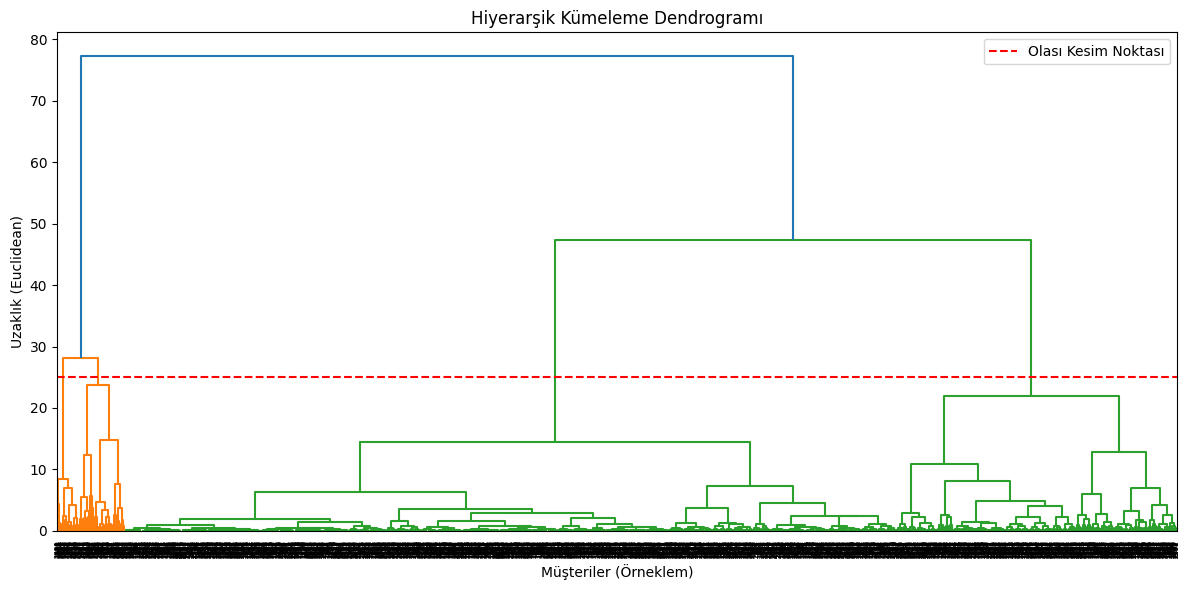

In [8]:
# ==========================================
# ADIM 6: DENDROGRAM GRAFİĞİ
# ==========================================
plt.figure(figsize=(12, 6))
plt.title('Hiyerarşik Kümeleme Dendrogramı')
plt.xlabel('Müşteriler (Örneklem)')
plt.ylabel('Uzaklık (Euclidean)')
# Ward metodu varyansı minimize eder, genelde en iyi ağacı bu verir.
dendrogram = sch.dendrogram(sch.linkage(X_sample, method='ward'))
plt.axhline(y=25, color='r', linestyle='--', label='Olası Kesim Noktası') # Görsel referans
plt.legend()
plt.tight_layout()
plt.show()

In [9]:

# ==========================================
# ADIM 7: EN İYİ K DEĞERİNİ BULMA
# ==========================================
print("\n🔄 En iyi k değeri aranıyor...")
silhouette_scores = []
k_range = range(2, 8) # 2'den 7'ye kadar dene

best_score = -1
best_k = 2

for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = hc.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k
    print(f"   -> k={k} Skor: {score:.4f}")

print(f"🏆 En İyi k Değeri: {best_k} (Skor: {best_score:.4f})")



🔄 En iyi k değeri aranıyor...
   -> k=2 Skor: 0.7628
   -> k=3 Skor: 0.5812
   -> k=4 Skor: 0.5826
   -> k=5 Skor: 0.5851
   -> k=6 Skor: 0.5336
   -> k=7 Skor: 0.5342
🏆 En İyi k Değeri: 2 (Skor: 0.7628)


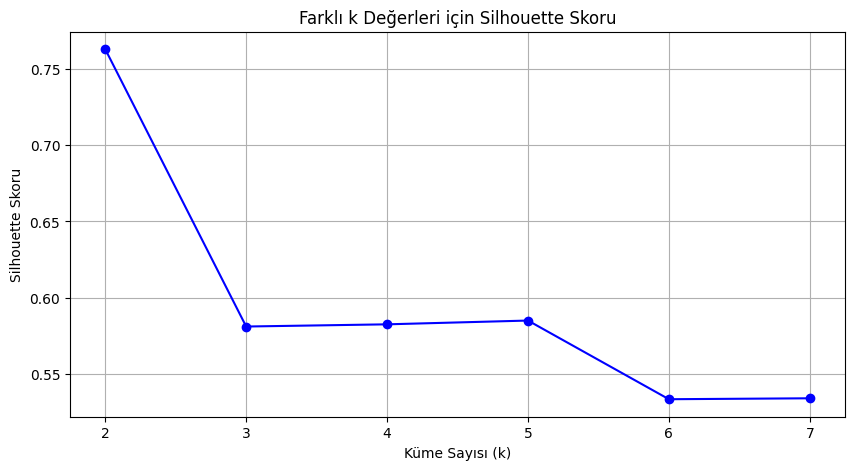

In [10]:
# ==========================================
# ADIM 8: K PERFORMANS GRAFİĞİ (ELBOW BENZERİ)
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Farklı k Değerleri için Silhouette Skoru')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Skoru')
plt.grid(True)
plt.xticks(k_range)
plt.show()

In [11]:

# ==========================================
# ADIM 9: ETİKETLEME VE KNN EĞİTİMİ
# ==========================================
# 1. Hiyerarşik ile etiketleri oluştur
hc_final = AgglomerativeClustering(n_clusters=best_k, metric='euclidean', linkage='ward')
y_sample_labels = hc_final.fit_predict(X_sample)

# 2. KNN'i eğit
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_sample, y_sample_labels)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [12]:
# ==========================================
# ADIM 10: TEST SETİ TAHMİNİ
# ==========================================
test_predictions = knn_model.predict(X_test_scaled)
test_score = silhouette_score(X_test_scaled, test_predictions)
print(f"\n📊 TEST SETİ Silhouette Skoru: {test_score:.4f}")



📊 TEST SETİ Silhouette Skoru: 0.7586


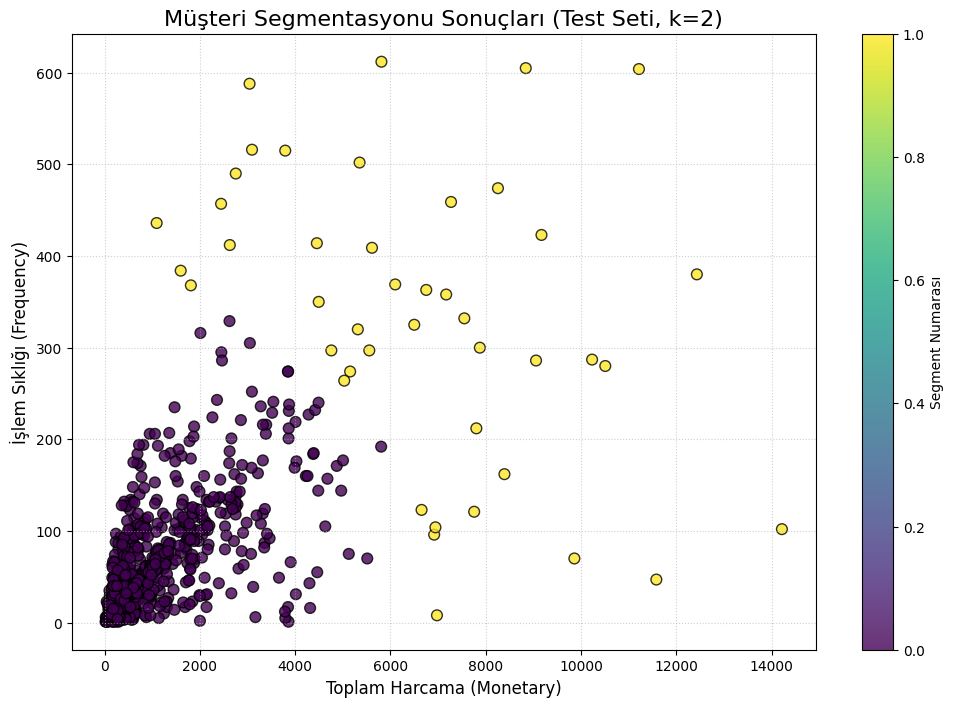

In [13]:
# ==========================================
# ADIM 11:  SCATTER PLOT
# ==========================================
test_real_values = scaler.inverse_transform(X_test_scaled)

plt.figure(figsize=(12, 8))

# Renk paletini değiştiriyoruz: 'viridis', 'plasma', 'coolwarm', 'Set1' gibi seçenekler var.
# 'Set1' belirgin, ayrık renkler verir.
scatter = plt.scatter(test_real_values[:, 0], test_real_values[:, 1], 
                      c=test_predictions, 
                      cmap='viridis', # İsteğe göre 'Set1' veya 'plasma' yapılabilir
                      s=60, 
                      alpha=0.8, 
                      edgecolors='k') # Noktaların etrafına siyah çizgi

plt.title(f'Müşteri Segmentasyonu Sonuçları (Test Seti, k={best_k})', fontsize=16)
plt.xlabel('Toplam Harcama (Monetary)', fontsize=12)
plt.ylabel('İşlem Sıklığı (Frequency)', fontsize=12)

# Lejantı (hangi renk hangi küme) göstermek için
plt.colorbar(scatter, label='Segment Numarası')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


In [14]:
# ==========================================
# ADIM 12: KÜMELERİN KARAKTER ANALİZİ 
# ==========================================

# Test seti tahminlerini DataFrame'e çevirelim
df_analiz = pd.DataFrame(scaler.inverse_transform(X_test_scaled), columns=['Monetary', 'Frequency'])
df_analiz['Segment'] = test_predictions

# Her kümenin ortalamasını ve eleman sayısını alalım
cluster_summary = df_analiz.groupby('Segment').agg({
    'Monetary': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Segment': 'count'
})

cluster_summary.columns = ['Mon_Ort', 'Mon_Min', 'Mon_Max', 'Freq_Ort', 'Freq_Min', 'Freq_Max', 'Kisi_Sayisi']

print("\n📊 KÜME ANALİZİ TABLOSU:")
print(cluster_summary)


📊 KÜME ANALİZİ TABLOSU:
             Mon_Ort  Mon_Min   Mon_Max    Freq_Ort  Freq_Min  Freq_Max  \
Segment                                                                   
0        1003.437870    20.80   5805.80   59.676692       1.0     329.0   
1        6587.822727  1093.65  14217.61  336.250000       8.0     612.0   

         Kisi_Sayisi  
Segment               
0                798  
1                 44  


In [15]:
# ==========================================================================
# ADIM 13: EN KALABALIK GRUBU BUL VE PARÇALA
# ==========================================================================
print("\n🔍 2. AŞAMA: En Kalabalık Grubun Derinlemesine Analizi...")

# 1. Ana küme etiketlerini kopyala
main_cluster_labels = y_sample_labels.copy()

# 2. Hangi küme en kalabalık? (OTOMATİK TESPİT)
counts = np.bincount(main_cluster_labels)
crowded_label_id = np.argmax(counts) 

print(f"   -> Sistem Tespiti: En kalabalık küme ID'si: {crowded_label_id} (Eleman Sayısı: {counts[crowded_label_id]})")
print(f"   -> Not: Bu küme parçalanacak, diğer küçük kümeler (VIP) korunacak.")

# 3. Maskeleme işlemini bu otomatik ID'ye göre yapalım
mask_crowded = (main_cluster_labels == crowded_label_id)
X_sub_sample = X_sample[mask_crowded]
print(f"   -> Alt kümeleme yapılacak veri sayısı: {len(X_sub_sample)}")

# 4. Alt grup için EN İYİ K DEĞERİNİ bulma döngüsü
print("   -> Alt grup için en iyi k aranıyor...")

best_sub_k = 2
best_sub_score = -1
sub_k_range = range(2, 7) 

for k in sub_k_range:
    hc_sub = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    sub_labels_temp = hc_sub.fit_predict(X_sub_sample)
    
    score = silhouette_score(X_sub_sample, sub_labels_temp)
    # print(f"      Alt k={k} için Skor: {score:.4f}") 
    
    if score > best_sub_score:
        best_sub_score = score
        best_sub_k = k

print(f"🏆 Alt Grup İçin KAZANAN k Değeri: {best_sub_k} (Skor: {best_sub_score:.4f})")



🔍 2. AŞAMA: En Kalabalık Grubun Derinlemesine Analizi...
   -> Sistem Tespiti: En kalabalık küme ID'si: 0 (Eleman Sayısı: 2819)
   -> Not: Bu küme parçalanacak, diğer küçük kümeler (VIP) korunacak.
   -> Alt kümeleme yapılacak veri sayısı: 2819
   -> Alt grup için en iyi k aranıyor...
🏆 Alt Grup İçin KAZANAN k Değeri: 2 (Skor: 0.6106)


In [19]:
# ==========================================
# ADIM 14: ETİKETLERİ BİRLEŞTİRME VE KNN EĞİTİMİ
# ==========================================

# 1. Kazanan k değeri ile nihai alt kümelemeyi yap
hc_sub_final = AgglomerativeClustering(n_clusters=best_sub_k, metric='euclidean', linkage='ward')
final_sub_labels = hc_sub_final.fit_predict(X_sub_sample)

# 2. Etiketleri Ana Yapıya Monte Etme
# DİKKAT: "00" yazabilmek için veriyi SAYI değil YAZI (String) yapmalıyız.
final_labels = main_cluster_labels.astype(str) # Önce hepsini yazıya çevir ("0", "1")

# Parçalanan kısmın yeni etiketlerini oluşturuyoruz:
# Mantık: "Ana Küme ID" + "Alt Küme ID" (Yan yana yaz)
# Örnek: Ana=0, Alt=1 --> "01"
new_sub_labels = [f"{crowded_label_id}{sub_lbl}" for sub_lbl in final_sub_labels]

# Maskelenmiş alana bu yeni yazı etiketlerini yapıştırıyoruz
final_labels[mask_crowded] = new_sub_labels

print(f"✅ Etiketler metin olarak birleştirildi. Yeni Segment ID'leri: {np.unique(final_labels)}")
# Beklenen Çıktı: ['00', '01', '1'] (Eğer 0 parçalandıysa)
print(f"✅ Etiketler birleştirildi. Yeni Segment ID'leri: {np.unique(final_labels)}")

# 3. KNN Modelini eğit
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(X_sample, final_labels)
print("🚀 KNN Modeli güncellenmiş segmentlerle eğitildi.")


✅ Etiketler metin olarak birleştirildi. Yeni Segment ID'leri: ['00' '01' '1']
✅ Etiketler birleştirildi. Yeni Segment ID'leri: ['00' '01' '1']
🚀 KNN Modeli güncellenmiş segmentlerle eğitildi.



📊 FİNAL TEST SETİ Silhouette Skoru: 0.5666


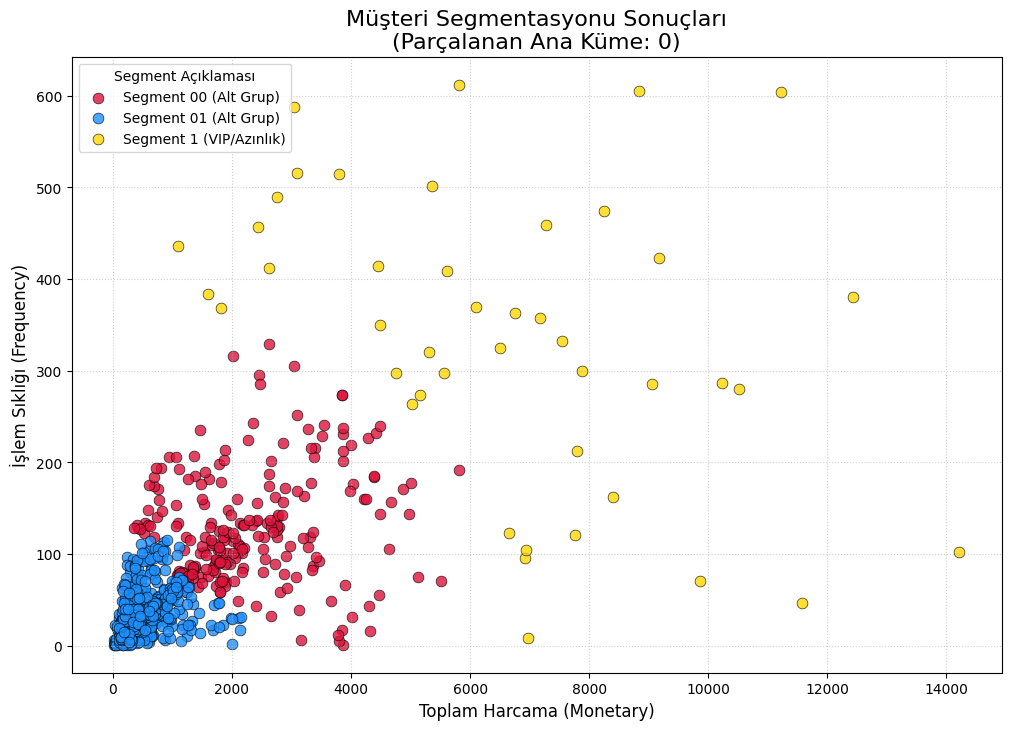

In [22]:

# ==========================================
# ADIM 15: TEST VE GÖRSELLEŞTİRME 
# ==========================================

# Test seti tahmini
test_predictions = knn_final.predict(X_test_scaled)
test_real_values = scaler.inverse_transform(X_test_scaled)

final_test_score = silhouette_score(X_test_scaled, test_predictions)
print(f"\n📊 FİNAL TEST SETİ Silhouette Skoru: {final_test_score:.4f}")

# --- Grafik Ayarları ---
unique_labels = np.unique(test_predictions)
# Renk Listesi: Her ID için sırayla bu renkleri kullanır
# Eğer segment sayısı 5'ten fazlaysa başa döner
custom_colors = ['crimson', 'dodgerblue', 'gold', 'forestgreen', 'purple', 'darkorange']

plt.figure(figsize=(12, 8))

# Her bir kümeyi döngüyle TEK TEK çiziyoruz (Renk karışmasını önlemek için)
for i, label in enumerate(unique_labels):
    mask = (test_predictions == label)
    
    # İsmini belirle
    # Eğer bu ID, kalabalık olan ID değilse VIP'dir (veya küçük gruptur)
    if label == crowded_label_id: # Bu teorik olarak mümkün değil çünkü +10 yaptık ama mantık kalsın
         label_name = f"Segment {label} (Ana Grup)"
    if len(str(label)) > 1:
        label_name = f"Segment {label} (Alt Grup)"
    else:
        # Eğer 10'dan küçükse, bu parçalanmayan VIP/Azınlık kümesidir.
        label_name = f"Segment {label} (VIP/Azınlık)"
    
    plt.scatter(test_real_values[mask, 0], 
                test_real_values[mask, 1], 
                color=custom_colors[i % len(custom_colors)], 
                s=60, 
                alpha=0.8, 
                edgecolors='black', 
                linewidth=0.5,
                label=label_name) # <-- Güncellenen isim burada kullanılıyor

plt.title(f'Müşteri Segmentasyonu Sonuçları\n(Parçalanan Ana Küme: {crowded_label_id})', fontsize=16)
plt.xlabel('Toplam Harcama (Monetary)', fontsize=12)
plt.ylabel('İşlem Sıklığı (Frequency)', fontsize=12)
plt.legend(title="Segment Açıklaması", loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [23]:
# ==========================================
# ADIM 16: FİNAL KARAKTER ANALİZİ
# ==========================================
df_final_analiz = pd.DataFrame(test_real_values, columns=['Monetary', 'Frequency'])
df_final_analiz['Segment'] = test_predictions

final_summary = df_final_analiz.groupby('Segment').agg({
    'Monetary': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Segment': 'count'
})

final_summary.columns = ['Mon_Ort', 'Mon_Min', 'Mon_Max', 'Freq_Ort', 'Freq_Min', 'Freq_Max', 'Kisi_Sayisi']
final_summary = final_summary.round(1)

print("\n📋 DETAYLI MÜŞTERİ PROFİL TABLOSU:")
print(final_summary)


📋 DETAYLI MÜŞTERİ PROFİL TABLOSU:
         Mon_Ort  Mon_Min  Mon_Max  Freq_Ort  Freq_Min  Freq_Max  Kisi_Sayisi
Segment                                                                      
00        2321.6    360.9   5805.8     130.0       1.0     329.0          224
01         489.0     20.8   2148.5      32.2       1.0     115.0          574
1         6587.8   1093.6  14217.6     336.2       8.0     612.0           44
